In [1]:
# Import.
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


In [2]:
# Download Data files.
!wget https: // cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https: // cdn.freecodecamp.org/project-data/sms/valid-data.tsv

# Define Paths.
train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"


--2022-12-31 14:47:09--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.04s   

2022-12-31 14:47:09 (8.90 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2022-12-31 14:47:09--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [7]:
# Define DataFrame.
df = pd.read_csv("train-data.tsv",
                 sep='\t',
                 header=None)
df.columns = ['label', 'message']

# Sneak peak of data.
df.describe()


,label,message
count,4179,4179
unique,2,3935
top,ham,"sorry, i'll call later"
freq,3619,22


In [9]:
# Categorize data in ham and spam.
ham_msg = df[df.label == 'ham']
spam_msg = df[df.label == 'spam']

# To numpy array. Needed to visualize using WordCloud.
ham_msg_numpy = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_numpy = " ".join(spam_msg.message.to_numpy().tolist())


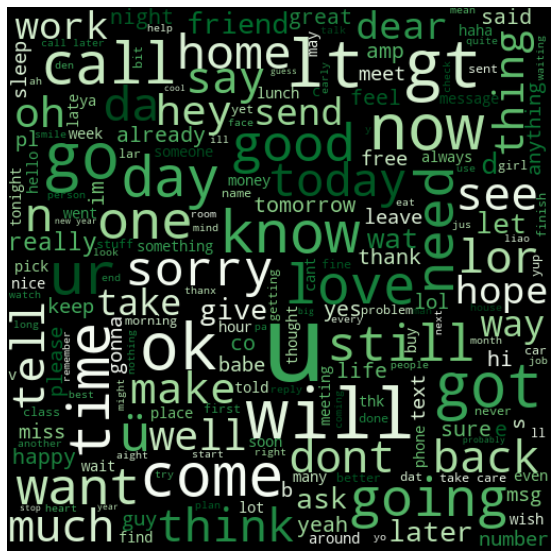

In [26]:
# Visualize using WordCloud. For ham words.
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

ham_msg_cloud = WordCloud(width=512, height=512, stopwords=STOPWORDS, max_font_size=100,
                          background_color="black", colormap='Greens').generate(ham_msg_numpy)

plt.figure(figsize=(10, 10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


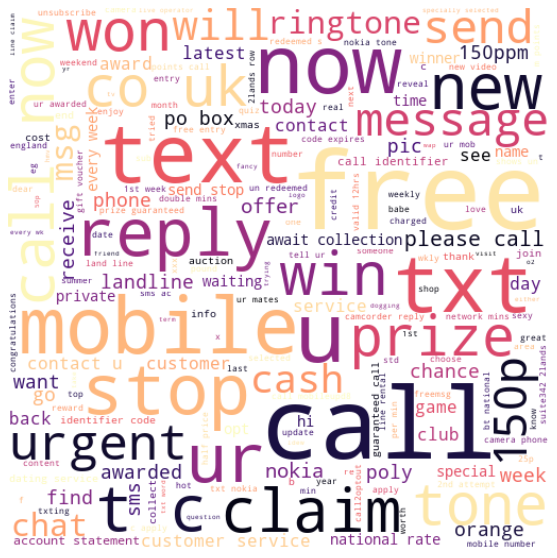

In [25]:
# Visualize using WordCloud. For spam words.
spam_msg_cloud = WordCloud(width=512, height=512, stopwords=STOPWORDS, max_font_size=100,
                           background_color="White", colormap="magma").generate(spam_msg_numpy)

plt.figure(figsize=(10, 10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


15 % of the messages, are spam.


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


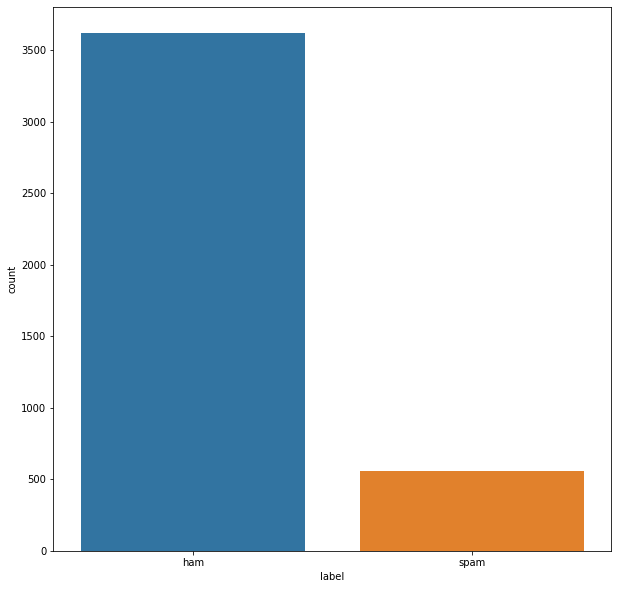

In [34]:
# Visualize using Seaborn.
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.countplot(df.label)

# Calculate percentage of spam messages.
spam_perc = (len(spam_msg)/len(ham_msg))*100
print(round(spam_perc), "% of the messages are spam.")


In [49]:
# Preprocessing
ham_msg_df = ham_msg.sample(n=len(spam_msg), random_state=0)
spam_msg_df = spam_msg

msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)

msg_df['text_length'] = msg_df['message'].apply(
    len)  # Calculate average length by label types
labels = msg_df.groupby('label').mean()

df_test = pd.read_csv("valid-data.tsv", sep='\t', header=None)
df_test.columns = ['label', 'message']

msg_df['msg_type'] = msg_df['label'].map({'ham': 0, 'spam': 1})
df_test['msg_type'] = df_test['label'].map({'ham': 0, 'spam': 1})

train_label = msg_df['msg_type']
train_msg = msg_df['message']
test_msg = df_test['message']
test_label = df_test['msg_type']


In [52]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
max_len = 50
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
vocab_size = 500

tokenizer = Tokenizer(num_words=vocab_size,
                      char_level=False, oov_token=oov_tok)
tokenizer.fit_on_texts(train_msg)

word_index = tokenizer.word_index
tot_words = len(word_index)

training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences(
    training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(
    testing_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)


In [39]:
# Dense Spam Detection Model.
vocab_size = 500
embeding_dim = 16
drop_value = 0.2
n_dense = 24
max_len = 50


In [53]:
# Design Model.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
____________________________________________________

In [54]:
# Compile the model.
from tensorflow.keras.callbacks import EarlyStopping
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

# Fit dense spam detector model.

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_label, epochs=num_epochs, validation_data=(
    testing_padded, test_label), callbacks=[early_stop], verbose=2)


Epoch 1/30
35/35 - 2s - loss: 0.6874 - accuracy: 0.5000 - val_loss: 0.6534 - val_accuracy: 0.8563 - 2s/epoch - 56ms/step
Epoch 2/30
35/35 - 1s - loss: 0.6691 - accuracy: 0.5991 - val_loss: 0.6154 - val_accuracy: 0.9030 - 583ms/epoch - 17ms/step
Epoch 3/30
35/35 - 0s - loss: 0.6280 - accuracy: 0.7437 - val_loss: 0.5178 - val_accuracy: 0.9102 - 319ms/epoch - 9ms/step
Epoch 4/30
35/35 - 0s - loss: 0.5677 - accuracy: 0.8134 - val_loss: 0.4367 - val_accuracy: 0.9138 - 222ms/epoch - 6ms/step
Epoch 5/30
35/35 - 0s - loss: 0.4902 - accuracy: 0.8723 - val_loss: 0.3873 - val_accuracy: 0.8987 - 145ms/epoch - 4ms/step
Epoch 6/30
35/35 - 0s - loss: 0.4032 - accuracy: 0.8973 - val_loss: 0.3016 - val_accuracy: 0.9116 - 134ms/epoch - 4ms/step
Epoch 7/30
35/35 - 0s - loss: 0.3349 - accuracy: 0.9062 - val_loss: 0.2799 - val_accuracy: 0.9066 - 142ms/epoch - 4ms/step
Epoch 8/30
35/35 - 0s - loss: 0.2753 - accuracy: 0.9116 - val_loss: 0.2453 - val_accuracy: 0.9167 - 141ms/epoch - 4ms/step
Epoch 9/30
35/35 

In [55]:
# Evaluate results
model.evaluate(testing_padded, test_label)


44/44 [==============================] - 0s 2ms/step - loss: 0.1006 - accuracy: 0.9691


[0.1006021499633789, 0.9691091775894165]

In [58]:
# TIME TO TEST

# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text1):
    pred_text = []
    pred_text.append(pred_text1)
    new_seq = tokenizer.texts_to_sequences(pred_text)
    padded = pad_sequences(new_seq, maxlen=max_len,
                           padding=padding_type, truncating=trunc_type)
    prediction = model.predict(padded)
    for i in prediction:
        if i > 0.5:
            return ((float(i), "spam"))
        else:
            return ((float(i), "ham"))


pred_text = " you have won £1000 cash! call to claim"

prediction = predict_message(pred_text)
print(prediction)


1/1 [==============================] - 0s 108ms/step
(0.9096307754516602, 'spam')


In [59]:

# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
    test_messages = ["how are you doing today",
                     "sale today! to stop texts call 98912460324",
                     "i dont want to go. can we try it a different day? available sat",
                     "our new mobile video service is live. just install on your phone to start watching.",
                     "you have won £1000 cash! call to claim your prize.",
                     "i'll bring it tomorrow. don't forget the milk.",
                     "wow, is your arm alright. that happened to me one time too"
                     ]

    test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
    passed = True

    for msg, ans in zip(test_messages, test_answers):
        prediction = predict_message(msg)
        if prediction[1] != ans:
            passed = False

    if passed:
        print("You passed the challenge. Great job!")
    else:
        print("You haven't passed yet. Keep trying.")


test_predictions()


1/1 [==============================] - 0s 27ms/step
You passed the challenge. Great job!
